# Loading dependencies and model

In [1]:
import os
import torch
from torchvision import datasets, transforms
from utils import loaders_by_classes, filter_loaders, balance
from classNet import ConvNet, submodel # for torch load
import matplotlib.pyplot as plt

In [2]:
_model = torch.load('./models/all_class.pth', weights_only=False)
_model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0,), (1,))  # Normalize images
])

test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
num_workers = os.cpu_count()
test_loaders = loaders_by_classes(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

# Choose class to Test

In [5]:
class_name = '0 - zero'
class_loader = test_loaders[class_name]


In [6]:
bal = balance(test_loaders)
n_items_class = bal[class_name]
n_tot = 0
for key, val in bal.items():
    if key != class_name:
        n_tot += val
proportion = n_items_class / n_tot
balanced_batch = (1 - proportion) * batch_size / proportion

In [7]:
filtered_loader = filter_loaders(test_loaders, class_name, balanced_batch, shuffle=True, num_workers=num_workers)

# Submodel

In [16]:
model = submodel(_model, 0)
model.to(device)


ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

# Gradients pour classic Loss 

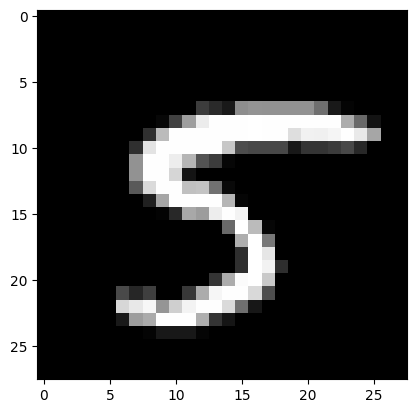

In [17]:
input = next(iter(filtered_loader))
plt.imshow(input[0][0].squeeze(), cmap='gray')

In [18]:
def get_param_grad_1(model, input, back_lay_num = 1):
    """
    Capture le gradient de la perte par rapport aux paramètres (poids et biais) du dernier layer paramétrique.

    Args:
        model (torch.nn.Module): Le modèle de réseau de neurones.
        input_tensor (torch.Tensor): Les données d'entrée pour le modèle.

    Returns:
        torch.Tensor: Gradient de la perte par rapport aux poids et biais du dernier layer paramétrique.
    """

    input_tensor, label_tensor = input
    input_tensor = input_tensor.to(device)
    label_tensor = label_tensor.to(device)

    # Assurez-vous que l'entrée a bien requires_grad activé
    input_tensor.requires_grad_(True)

    # Passer en avant jusqu'au dernier layer paramétrique
    model.zero_grad()
    output = model(input_tensor)

    # Calcul de la perte et rétropropagation
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, label_tensor)
    loss.backward()

    # Récupérer le gradient des poids et biais du layer paramétrique
    layer = list(model.children())[- back_lay_num]  # Dernier layer du modèle

    # Liste pour stocker les gradients de chaque paramètre
    grad_params = []

    for param in layer.parameters():
        # Aplatir les gradients des paramètres (poids et biais)
        grad_params.append(param.grad.flatten())  # Aplatir les gradients des poids et biais

    # Concaténer tous les gradients (poids et biais) pour obtenir une seule dimension
    all_gradients = torch.cat(grad_params, dim=0)  # Contient tous les gradients

    # Test
    # Calcul du nombre total de paramètres dans le dernier layer paramétrique
    total_params = sum(p.numel() for p in layer.parameters()) # Total des paramètres (poids + biais)

    if all_gradients.numel() != total_params:
        raise RuntimeError(f"Erreur de taille : taille de all_gradients ({all_gradients.numel()}) ne correspond pas à "
                             f"total_params ({total_params})")

    # Retourner le gradient sous la forme (batch_size, total_params)
    return all_gradients

In [19]:
try:
    grad_1 = get_param_grad_1(model, input)
    print("Gradient size:", grad_1.size())  # Devrait donner (batch_size, nombre_de_paramètres)
    print(grad_1)
except RuntimeError as e:
    print(e)

Gradient size: torch.Size([1161])
tensor([ 0.2051,  0.0445,  0.1187,  ..., -0.0625, -0.0390, -0.0781],
       device='mps:0')


# Gradient pour Target Loss

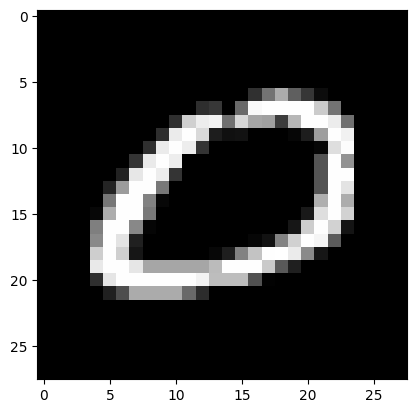

In [20]:
input = next(iter(class_loader))
# plot un example d'image input
plt.imshow(input[0][0].squeeze(), cmap='gray')

In [23]:
def get_output_target(output, class_num):
    output_excluded = torch.cat([output[:, :class_num], output[:, class_num+1:]], dim=1)
    _output_excluded = output_excluded.detach()
    target = _output_excluded - torch.mean(_output_excluded, dim=1, keepdim=True)
    return output_excluded, target

def get_param_grad_2(model, input, back_lay_num = 1):
    """
    Capture le gradient de la perte par rapport aux paramètres (poids et biais) du dernier layer paramétrique.

    Args:
        model (torch.nn.Module): Le modèle de réseau de neurones.
        input_tensor (torch.Tensor): Les données d'entrée pour le modèle.

    Returns:
        torch.Tensor: Gradient de la perte par rapport aux poids et biais du dernier layer paramétrique.
    """

    input_tensor, label_tensor = input
    input_tensor = input_tensor.to(device)
    label_tensor = label_tensor.to(device)

    # Assurez-vous que l'entrée a bien requires_grad activé
    input_tensor.requires_grad_(True)

    # Passer en avant jusqu'au dernier layer paramétrique
    model.zero_grad()
    output = model(input_tensor)

    # Création de la cible
    output_excluded, target = get_output_target(output, class_num = 0)

    # Calcul de la perte et rétropropagation
    loss = torch.nn.functional.mse_loss(output_excluded, target)
    loss.backward()

    # Récupérer le gradient des poids et biais du layer paramétrique
    layer = list(model.children())[- back_lay_num]  # Dernier layer du modèle

    # Liste pour stocker les gradients de chaque paramètre
    grad_params = []

    for param in layer.parameters():
        # Aplatir les gradients des paramètres (poids et biais)
        grad_params.append(param.grad.flatten())  # Aplatir les gradients des poids et biais

    # Concaténer tous les gradients (poids et biais) pour obtenir une seule dimension
    all_gradients = torch.cat(grad_params, dim=0)  # Contient tous les gradients

    # Test
    # Calcul du nombre total de paramètres dans le dernier layer paramétrique
    total_params = sum(p.numel() for p in layer.parameters()) # Total des paramètres (poids + biais)

    if all_gradients.numel() != total_params:
        raise RuntimeError(f"Erreur de taille : taille de all_gradients ({all_gradients.numel()}) ne correspond pas à "
                             f"total_params ({total_params})")

    # Retourner le gradient sous la forme (batch_size, total_params)
    return all_gradients

In [24]:
try:
    grad_2 = get_param_grad_2(model, input)
    print("Gradient size:", grad_2.size())  # Devrait donner (batch_size, nombre_de_paramètres)
    print(grad_2)
except RuntimeError as e:
    print(e)

Gradient size: torch.Size([1161])
tensor([ 0.0000,  0.0271,  0.0045,  ..., -0.3390, -0.9513, -0.1273],
       device='mps:0')


# Calcul Masking

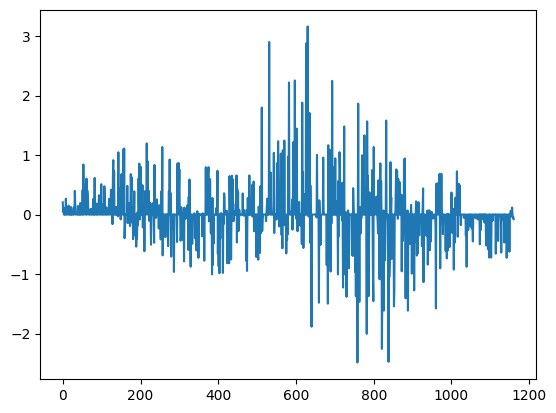

In [25]:
plt.plot(grad_1.detach().cpu().numpy())

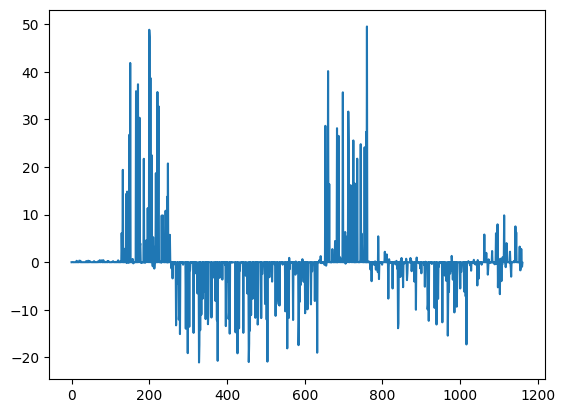

In [26]:
plt.plot(grad_2.detach().cpu().numpy())

In [27]:
mask = grad_1 * grad_2 > 0
torch.sum(mask)

tensor(347, device='mps:0')

In [ ]:

back_lay_num = 1
layer = list(model.children())[- back_lay_num]
params = layer.parameters()
list_params = list(params)
list_params

RuntimeError: The size of tensor a (1290) must match the size of tensor b (1161) at non-singleton dimension 0

In [ ]:
filtered_params = [p for p, m in zip(params, mask) if m]
filtered_params

[]

In [ ]:
wgt, bias = list_params[0], list_params[1]
wgt, bias

(Parameter containing:
 tensor([[-0.1386,  0.1189, -0.1357,  ...,  0.0622,  0.0444, -0.0596],
         [ 0.0602,  0.0746,  0.0614,  ...,  0.0468, -0.1018, -0.0262],
         [-0.2365,  0.0751,  0.0738,  ...,  0.0325,  0.0142, -0.0390],
         ...,
         [-0.1448, -0.1523,  0.0451,  ..., -0.1763, -0.0253, -0.0100],
         [ 0.0359, -0.0877, -0.0979,  ...,  0.1001, -0.1611,  0.0632],
         [ 0.0805,  0.0698,  0.0568,  ..., -0.1275,  0.0459,  0.0399]],
        device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0903,  0.0220, -0.0523,  0.0591,  0.0151, -0.0137,  0.0476, -0.0684,
          0.0690, -0.0051], device='mps:0', requires_grad=True))

In [ ]:
optimizer = torch.optim.Adam()